In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import joblib

In [4]:
# Load the dataset
train_file_path = "train.csv"
test_file_path = "test.csv"
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
# Display the first few rows of the dataframe
train_df.head()

,company_id,company_name,industry,funding_rounds,total_funding,last_funding_date,job_postings_30d,employee_growth_pct,hiring_roles,industry_growth_rate,regional_employment_trend,funding_per_employee,days_since_last_funding,growth_momentum,is_hot_lead
0,COMP_024008,Moreno and Sons,Retail,1.911533,3795597.04,2021-07-14,10.995177,-8.355216,Operations,11.5,-0.2,-5930.620375,1317,45547164.48,0
1,COMP_007976,"Morales, Hubbard and Mcdonald",Healthcare,3.221005,5792195.29,2020-05-23,5.052385,20.602718,Marketing,23.9,10.5,2106.252833,1734,34753171.74,0
2,COMP_021959,Strickland-Wright,Tech,3.975966,191991.00,2020-05-07,5.008945,0.456013,Operations,20.5,-1.5,1371.364286,1750,959955.00,0
3,COMP_012658,Sanders Group,Fintech,2.842382,890042.57,2023-04-11,9.882709,1.202142,Operations,23.2,13.9,4238.297952,681,8010383.13,0
4,COMP_011887,Davis Inc,Retail,2.264359,3369725.77,2024-03-27,11.461475,22.633126,Marketing,9.0,8.6,1567.314312,330,40436709.24,1


In [5]:
# Check for missing values
print("\nMissing values in each column:")
print(train_df.isnull().sum())


Missing values in each column:
company_id                   0
company_name                 0
industry                     0
funding_rounds               0
total_funding                0
last_funding_date            0
job_postings_30d             0
employee_growth_pct          0
hiring_roles                 0
industry_growth_rate         0
regional_employment_trend    0
funding_per_employee         0
days_since_last_funding      0
growth_momentum              0
is_hot_lead                  0
dtype: int64


In [6]:
# Display basic statistics
print("\nBasic statistics of the dataset:")
train_df.describe()


Basic statistics of the dataset:


C:\Users\jayak\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,funding_rounds,total_funding,job_postings_30d,employee_growth_pct,industry_growth_rate,regional_employment_trend,funding_per_employee,days_since_last_funding,growth_momentum,is_hot_lead
count,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,2.000000e+04,20000.000000
mean,2.987775,4.171424e+06,10.002013,19.954379,17.456325,5.133810,inf,909.826000,4.188535e+07,0.149250
std,1.454144,3.088695e+06,3.328233,17.532040,7.232038,5.767425,NaN,527.341786,3.525597e+07,0.356344
min,0.686082,1.004476e+05,0.926065,-12.491863,5.000000,-5.000000,-7.894026e+05,1.000000,2.957271e+05,0.000000
25%,1.954142,1.719901e+06,7.640501,4.824062,11.200000,0.200000,3.183275e+02,455.000000,1.532106e+07,0.000000
50%,2.869536,3.533375e+06,9.733120,19.865427,17.400000,5.200000,1.181334e+03,905.000000,3.279494e+07,0.000000
75%,3.868760,5.976700e+06,12.056417,34.704816,23.700000,10.200000,2.786092e+03,1363.000000,5.888261e+07,0.000000
max,13.013271,2.141484e+07,29.457835,64.173316,30.000000,15.000000,inf,1827.000000,3.239826e+08,1.000000


In [7]:
train_df["last_funding_date"] = pd.to_datetime(train_df["last_funding_date"], errors="coerce")
test_df["last_funding_date"] = pd.to_datetime(test_df["last_funding_date"], errors="coerce")

# Feature engineering: Extract year and month from last_funding_date
train_df["last_funding_year"] = train_df["last_funding_date"].dt.year
train_df["last_funding_month"] = train_df["last_funding_date"].dt.month
test_df["last_funding_year"] = test_df["last_funding_date"].dt.year
test_df["last_funding_month"] = test_df["last_funding_date"].dt.month

In [8]:
# Encode categorical feature (industry)
label_encoder = LabelEncoder()
train_df["industry"] = label_encoder.fit_transform(train_df["industry"])
test_df["industry"] = label_encoder.transform(test_df["industry"])

In [9]:
# Replace infinite values in funding_per_employee and fill NaNs
upper_bound = train_df["funding_per_employee"].quantile(0.99)
train_df["funding_per_employee"].replace([np.inf, -np.inf], np.nan, inplace=True)
train_df["funding_per_employee"].fillna(train_df["funding_per_employee"].median(), inplace=True)
train_df["funding_per_employee"] = train_df["funding_per_employee"].clip(upper=upper_bound)

test_df["funding_per_employee"].replace([np.inf, -np.inf], np.nan, inplace=True)
test_df["funding_per_employee"].fillna(train_df["funding_per_employee"].median(), inplace=True)
test_df["funding_per_employee"] = test_df["funding_per_employee"].clip(upper=upper_bound)

C:\Users\jayak\AppData\Local\Temp\ipykernel_18180\2613513416.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["funding_per_employee"].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\jayak\AppData\Local\Temp\ipykernel_18180\2613513416.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [10]:
train_df.drop(columns=["company_id", "company_name", "last_funding_date", "hiring_roles"], inplace=True)
test_df.drop(columns=["company_name", "last_funding_date", "hiring_roles"], inplace=True)

In [11]:
X_train = train_df.drop(columns=["is_hot_lead"])
y_train = train_df["is_hot_lead"]
X_test = test_df.drop(columns=["company_id","is_hot_lead"], errors='ignore')
y_test= test_df["is_hot_lead"]

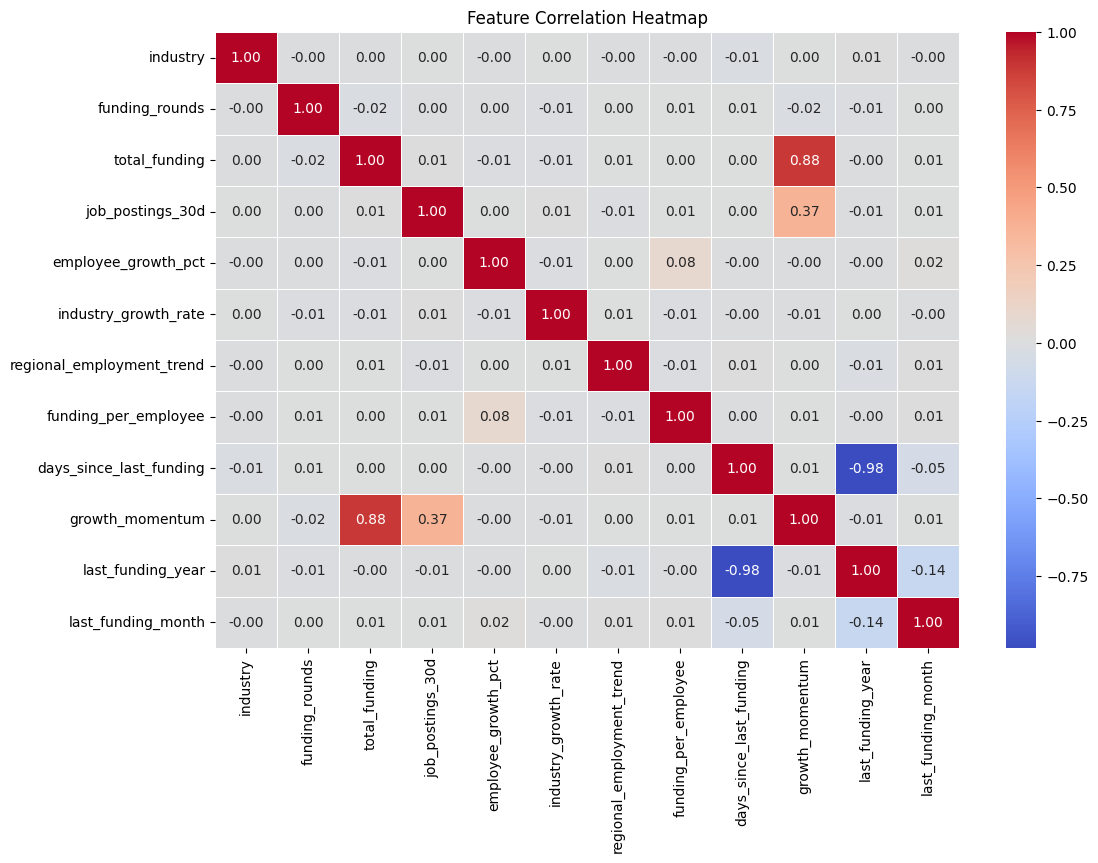

In [12]:
# Compute correlation matrix
corr_matrix = X_train.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [15]:
y_pred = rf_model.predict(X_test_scaled)

In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [17]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9558
Precision: 0.8561736770691994
Recall: 0.8458445040214477
F1 Score: 0.8509777478084963
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      4254
           1       0.86      0.85      0.85       746

    accuracy                           0.96      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.96      0.96      0.96      5000



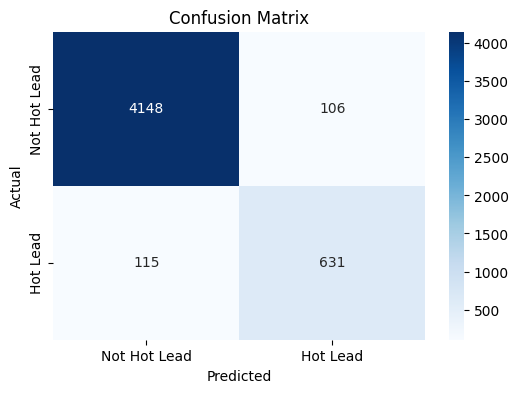

In [18]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Hot Lead", "Hot Lead"], yticklabels=["Not Hot Lead", "Hot Lead"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [31]:
import joblib
# Save the model as a pickle file
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']

In [19]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']